In [13]:
import numpy as np
from scipy.stats import multivariate_normal
from scipy.special import logsumexp
import matplotlib.pyplot as plt
import math 

# **1) GENERATION DES DONNEES**

In [2]:
def generate_z(A,b,K,cov,x):
    z_O = []
    z_E = []
    for i in range(int(2**K)):
        z_O.append(np.random.multivariate_normal(A*x+b, (2/3)*cov))
        z_E.append(np.random.multivariate_normal(A*x+b, (2/3)*cov))
    z = z_O.copy()
    z.extend(z_E)
    return z, z_O, z_E

In [3]:
def generate_q_p(A,b,K,mean,cov,x,z,z_O,z_E):
    q = []
    p = []
    q_O = []
    p_O = []
    q_E = []
    p_E = []
    for i in range(int(2**(K+1))):
        q.append(multivariate_normal.pdf(z[i], mean=A*x+b, cov=(2/3)*cov))
        p.append(multivariate_normal.pdf(z[i], mean=mean, cov=cov)*multivariate_normal.pdf(x, mean=z[i], cov=cov))
    for i in range(int(2**(K))):
        q_O.append(multivariate_normal.pdf(z_O[i], mean=A*x+b, cov=(2/3)*cov))
        p_O.append(multivariate_normal.pdf(z_O[i], mean=mean, cov=cov)*multivariate_normal.pdf(x, mean=z_O[i], cov=cov))
        q_E.append(multivariate_normal.pdf(z_E[i], mean=A*x+b, cov=(2/3)*cov))
        p_E.append(multivariate_normal.pdf(z_E[i], mean=mean, cov=cov)*multivariate_normal.pdf(x, mean=z_E[i], cov=cov))
    return q, p, q_O, p_O, q_E, p_E

In [4]:
def SS_estimator(n_sim, mean, cov, A, b, r, theta):
    ss = []
    for i in range(n_sim):
        K = np.random.geometric(r, 1)
        x = np.random.multivariate_normal(np.zeros(20)+theta, 2*cov)
        z, z_O, z_E = generate_z(A,b,K,cov,x)
        q, p, q_O, p_O, q_E, p_E = generate_q_p(A,b,K,mean,cov,x,z,z_O,z_E)
        w = np.log(p) - np.log(q)
        w_O = np.log(p_O) - np.log(q_O)
        w_E = np.log(p_E) - np.log(q_E)
            
        #third step : compute I0
        I0 = w.mean()

        #fourth step : compute Lo and Le
            # Lo
        l_O = logsumexp(w_O) - np.log(len(w_O))    
            #Le
        l_E = logsumexp(w_E) - np.log(len(w_E))    

        #fifth step : compute L_O_E
        L_O_E = logsumexp(w) - np.log(len(w))
    
        #DeltaK
        DeltaK = L_O_E - 0.5*(l_O + l_E)
    
        #sixth step : compute the final estimator
        ml_ll_ss = I0 + (DeltaK/(r*(1-r)**(int(K)-1)))
        
        ss.append(ml_ll_ss)
    mean_value = np.mean(ss)
    std_error_value = np.std(ss) / np.sqrt(len(ss))

    return mean_value

#print("Mean: " + str(mean_value) + "\n" + "Standard error: " + str(std_error_value))

# **ESTIMATION DU GRADIENT**

In [46]:
y = []
x = []
theta = np.random.normal(0,1)
print(theta)
liste = np.linspace(-3,3,60)
for k in liste:
    y.append(SS_estimator(1000, np.zeros(20)+k, np.identity(20), 1, 0, 0.6,theta))
    x.append(k)

-0.09786099706596058


In [47]:
cleaned_y = [x for x in y if (math.isnan(x)==False)]
cleaned_x = [x[i] for i in range(len(x)) if (math.isnan(y[i])==False)]

In [48]:
grad = np.gradient(cleaned_y)

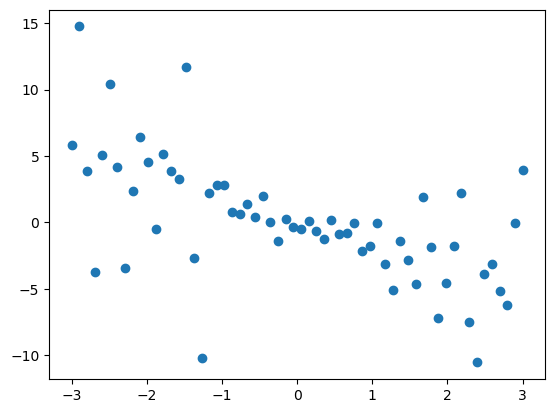

In [49]:
plt.scatter(cleaned_x,grad)